In [1]:
import pandas as pd
import datetime
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce
import numpy as np
import math

In [2]:
def getDateFromUTC(utc):
    return datetime.datetime.fromtimestamp(utc).strftime("%b %d %Y %H:%M:%S")

In [ ]:
# Download and unzip the collected logs

!wget https://www.dropbox.com/s/mx52ex1t64wqc7z/signalcapturer_collected_logs.zip
!unzip signalcapturer_collected_logs.zip

In [4]:
uploads_folder_name = 'signalcapturer_collected_logs'

assert os.path.exists(uploads_folder_name)

err_file_path = './err_logs'
with open(err_file_path, "w") as err_file:
    err_file.write(f'Err log created at {datetime.datetime.now().strftime("%b %d %Y %H:%M:%S")} for {uploads_folder_name}\n\n')

In [5]:
TRIM_SIGNALS = [
    ("normal", 0),
    ("moderate", 5),
    ("low", 10),
    ("critical", 15),
    ("ui_hidden", 20),
    ("mem_background", 40),
    ("mem_moderate", 60),
    ("mem_complete", 80),
]

TRIM_SIGNAL_NAME = {
    0: "normal",
    5: "moderate",
    10: "low",
    15: "critical",
    20: "ui_hidden",
    40: "mem_background",
    60: "mem_moderate",
    80: "mem_complete"
}

In [6]:
def get_parsed_results_as_df(uploads_folder_name, total_device_mem, uploadfile_name, err_file):
    """read the file line by line and parse it into a dataframe"""

    rows = []
    
    with open(f'{uploads_folder_name}/{uploadfile_name}') as f:

        for line in f.readlines():

            line = line.split()

            if line[0] == 'M:' or line[0] == 'D:':
                
                try:

                    row = {}

                    if re.fullmatch(r'\d{13}', line[1]) == None:
                        raise Exception(f"{line[1]} time not alright")

                    # get the time
                    row["orig_time"] = (line[1])
                    row["time"] = ((float(line[1])/1000))
                    
                    # get the memory available
                    row["mem_avail"] = (mem_avail := float(line[3])/(1024*1024))
                    if mem_avail > total_device_mem or mem_avail < 0.01 * total_device_mem:
                        raise Exception(f"{mem_avail} MB can't be available in a {total_device_mem} MB device")
                    
                    # get current mem pressure state
                    row["pressure"] = (pressure := int(line[4]))
                    if row["pressure"] not in [sig[1] for sig in TRIM_SIGNALS]:
                        raise Exception(f"{pressure} is not a valid trim signal value")
                    
                    def get_bool_from_int(name, val):
                        if val == 1:
                            return True
                        elif val == 0:
                            return False
                        else:
                            raise Exception(f"{val} is not a valid bool value for {name}")
                    
                    next_names = ["is_screen_on", "is_in_power_save", "is_battery_low", "is_music_playing"]
                    for i, name in enumerate(next_names):
                        row[name] = get_bool_from_int(name, int(line[5 + i]))

                    rows.append(row)

                except Exception as e:
                    
                    err_file.write(f"{e} in {line}\n")
                    

    return pd.DataFrame(rows, columns=["orig_time", "time", "mem_avail", "pressure", "is_screen_on", "is_in_power_save", "is_battery_low", "is_music_playing"])

In [7]:
def get_actual_days_logged(uploadfile_name, total_device_mem, max_diff_in_seconds, err_file):
    
    df = get_parsed_results_as_df(uploads_folder_name, total_device_mem, uploadfile_name, err_file)
    
    if len(df) == 0:
        
        # if no logs, return zero values for (num_of_neg_time_diffs, time_not_logged, time_logged, time_in, intervals_not_logged, overestimate, last_time_logged)
        
        time_in_pressure = {}
        for trim_signal in TRIM_SIGNALS:
            time_in_pressure[trim_signal[0]] = 0
        
        time_in = {"interactive": 0, "power_save": 0, "battery_low": 0, "music_playing": 0}
        
        return 0, 0, 0, time_in_pressure, time_in, None, 0, 0, df

    # add prev time and time differences to the df
    df["prev_time"] = df["time"].copy().shift(periods=1, fill_value=df["time"][0])
    df["time_diff"] = (df["time"] - df["prev_time"])

    """following times/intervals are calculated based on our assumed max_diff_in_seconds"""

    # see if some time_diff is -ve
    df_negative_time_diff = df.loc[df["time_diff"] < 0]
    num_of_neg_time_diffs = len(df_negative_time_diff)

    df = df.loc[df["time_diff"] >= 0]

    # effective prev_time i.e. the prev_time if the time_diff <= max_diff else time - max_diff
    df["eff_prev_time"] = df["prev_time"].copy()
    df.loc[df["time_diff"] > max_diff_in_seconds, "eff_prev_time"] = df.loc[df["time_diff"] > max_diff_in_seconds, "time"] - max_diff_in_seconds
    df["eff_time_diff"] = (df["time"] - df["eff_prev_time"]).copy()
    df["time_diff_not_logged"] = (df["eff_prev_time"] - df["prev_time"]).copy()

    # get the time that we assume that we don't have logging for
    time_not_logged = df.loc[df["time_diff"] > max_diff_in_seconds]["time_diff_not_logged"].sum()

    df_times_logged = df[["time", "eff_time_diff", "eff_prev_time", "time_diff_not_logged", "mem_avail", "pressure", "is_screen_on", "is_in_power_save", "is_battery_low", "is_music_playing"]].copy()

    # get the time that we assume that we have logged
    time_logged = df_times_logged["eff_time_diff"].sum()

    # get the time for which the phone was in a particular memory state
    def get_time_in_pressure(pressure_value):
        return df_times_logged.loc[df["pressure"] == pressure_value]["eff_time_diff"].sum(), df_times_logged.loc[df["pressure"] == pressure_value].loc[df["is_screen_on"] == True]["eff_time_diff"].sum()
    time_in_pressure = {}
    for trim_signal in TRIM_SIGNALS:
        time_in_pressure[trim_signal[0]], time_in_pressure[trim_signal[0] + "_i"] = get_time_in_pressure(trim_signal[1])

    # get the time for which the phone was interactive, in powersave, when battery was low and when music was playing
    time_in = {}
    time_in["interactive"] = df_times_logged.loc[df["is_screen_on"] == True]["eff_time_diff"].sum()
    time_in["power_save"] = df_times_logged.loc[df["is_in_power_save"] == True]["eff_time_diff"].sum()
    time_in["battery_low"] = df_times_logged.loc[df["is_battery_low"] == True]["eff_time_diff"].sum()
    time_in["music_playing"] = df_times_logged.loc[df["is_music_playing"] == True]["eff_time_diff"].sum()
    time_in["i_music_playing"] = df_times_logged.loc[df["is_screen_on"] == True].loc[df["is_music_playing"] == True]["eff_time_diff"].sum()

    # get the intervals for which logging was not done
    df_times_not_logged = df.loc[df["time_diff_not_logged"] > 0].copy()
    df_times_not_logged["intervals"] = list(zip(df_times_not_logged["prev_time"], df_times_not_logged["eff_prev_time"]))
    intervals_not_logged = pd.IntervalIndex(list(map(lambda interval: pd.Interval(interval[0], interval[1], closed='both'), df_times_not_logged["intervals"])), \
        copy=True, verify_integrity=True)
    
    # get an estimate of the amount of time we are overestimating if the time b/w two consecutive logs should we strictly 1s
    df["time_minus_1"] = df["eff_time_diff"] - 1
    df_less_diff = df.loc[df["time_diff_not_logged"] == 0].loc[df["time_minus_1"] > 0]
    overestimate = df_less_diff["time_minus_1"].sum()

    last_time_logged = df.loc[len(df) - 1]["time"]

    return num_of_neg_time_diffs, time_not_logged, time_logged, time_in_pressure, time_in, intervals_not_logged, overestimate, last_time_logged, df_times_logged

# with open(err_file_path, 'a') as err_file:
#     display(get_actual_days_logged('1773ec5085551e92_HUAWEI_signalsLogger.txt', 3712.265625, 5*60, err_file))

In [9]:
def get_all_configs():
    return [dir for dir in os.listdir(uploads_folder_name) if dir[:6] == 'Config' and "Itel" not in dir]

In [10]:
def is_any_true(acc, element):
    return acc or element

def is_in_interval(intervals, time):
    return intervals.contains(time).any()

In [11]:
def get_bool_from_int(name, val):
    if val == 1:
        return True
    elif val == 0:
        return False
    else:
        raise Exception(f"{val} is not a valid bool value for {name}")

In [12]:
parsed_columns = [
    "file_name",
    "age_group",
    "How often are games played on this device?",
    "How often are videos streamed on this device e.g. on YouTube, Facebook, Tiktok, or a web browser etc.?",
    "How often is music listened to on this device?",
    "How often does the device user multitask with more than one app?",
    "How often does the device user multitask with more than two apps?",
    "Any other memory/cpu intensive activity in your knowledge that is performed on this device? (e.g. video editing, BitTorrent, etc.)",
    "manufacturer",
    "total_memory",
    "threshold",
    "isLowRAM",
    "cpu_cores",
    "API_level",
    "time_logged",
    "time_interactive",
    "num_of_neg_time_diffs",
    "time_not_logged",
    "time_overestimate",
    "last_time_logged",
    "mem_avail_mean",
    "mem_avail_std",
    "mem_avail_min",
    "mem_avail_25%",
    "mem_avail_median",
    "mem_avail_75%",
    "mem_avail_max",
    "mem_util_mean",
    "mem_util_std",
    "mem_util_min",
    "mem_util_25%",
    "mem_util_median",
    "mem_util_75%",
    "mem_util_max",
    "time_normal",
    "time_normal_i",
    "time_moderate",
    "time_low",
    "time_critical",
    "time_ui_hidden",
    "time_ui_hidden_i",
    "time_mem_background",
    "time_mem_background_i",
    "time_mem_moderate",
    "time_mem_moderate_i",
    "time_mem_complete",
    "time_mem_complete_i",
    "time_power_save",
    "time_battery_low",
    "time_music_playing",
    "time_i_music_playing",
    "sigs_not_logged",
    "isigs_that_dont_have_m_logged",
    "sigs_count",
    "sigs_per_hour",
    "isigs_count",
    "isigs_per_hour",
    "time_isigs",
    "imsigs_per_hour",
    "isigs_%agetime",
    "moderate_count",
    "moderate_per_hour",
    "moderate_count_i",
    "moderate_i_per_hour",
    "time_moderate_i",
    "moderate_i_%agetime",
    "moderatemem_avail_mean",
    "moderatemem_avail_std",
    "moderatemem_avail_min",
    "moderatemem_avail_25%",
    "moderatemem_avail_median",
    "moderatemem_avail_75%",
    "moderatemem_avail_max",
    "moderate_count_im",
    "moderate_im_per_hour",
    "low_count",
    "low_per_hour",
    "low_count_i",
    "low_i_per_hour",
    "time_low_i",
    "low_i_%agetime",
    "lowmem_avail_mean",
    "lowmem_avail_std",
    "lowmem_avail_min",
    "lowmem_avail_25%",
    "lowmem_avail_median",
    "lowmem_avail_75%",
    "lowmem_avail_max",
    "low_count_im",
    "low_im_per_hour",
    "critical_count",
    "critical_per_hour",
    "critical_count_i",
    "critical_i_per_hour",
    "time_critical_i",
    "critical_i_%agetime",
    "criticalmem_avail_mean",
    "criticalmem_avail_std",
    "criticalmem_avail_min",
    "criticalmem_avail_25%",
    "criticalmem_avail_median",
    "criticalmem_avail_75%",
    "criticalmem_avail_max",
    "critical_count_im",
    "critical_im_per_hour",
    "other_sig_count",
    "overall_mems_df",
    "moderate_mems_df",
    "low_mems_df",
    "critical_mems_df",
]

In [13]:
def get_results(min_diff, print_progress=False):
    config_files =  get_all_configs()
    # config_files =  ["Configuration_1773ec5085551e92_HUAWEI_signalsLogger.txt"]

    with open(err_file_path, 'a') as err_file:
        to_write = "\n\n\n\n===================================\n" + \
            f"Started at {datetime.datetime.now().strftime('%b %d %Y %H:%M:%S')} for min_diff={min_diff}s\n\n"
        err_file.write(to_write)

    rows = []

    for config_file_num, config_file_name in enumerate(config_files):

        with open(err_file_path, 'a') as err_file:
            to_write = "===================================\n" + \
                f"Errors for: {config_file_name.replace('Configuration_', '')}\n\n"
            err_file.write(to_write)

        uploadfile_name = uploads_folder_name + config_file_name.replace('Configuration_', '')

        if not os.path.exists(uploadfile_name):

            with open(err_file_path, 'a') as err_file:
                err_file.write('not exists: ' + uploadfile_name + '\n')

        else:

            with open(err_file_path, 'a') as err_file:

                with open(uploads_folder_name + config_file_name) as config_file:

                    last_line = list(config_file.readlines())[-1].strip().split('\t')

                    if last_line[0] != 'C:':

                        err_file.write(f"config format wrong for {config_file_name}\n")

                    else:

                        l = last_line

                        row = {
                            "file_name": config_file_name.replace('Configuration_', ''), "age_group":    l[2],
                            "How often are games played on this device?": l[3],
                            "How often are videos streamed on this device e.g. on YouTube, Facebook, Tiktok, or a web browser etc.?": l[4],
                            "How often is music listened to on this device?": l[5],
                            "How often does the device user multitask with more than one app?": l[6],
                            "How often does the device user multitask with more than two apps?": l[7],
                            "Any other memory/cpu intensive activity in your knowledge that is performed on this device? (e.g. video editing, BitTorrent, etc.)": l[8],
                            "manufacturer": l[9],
                            "total_memory": int(l[10])/(1024*1024),
                            "threshold":    int(l[11]),
                            "isLowRAM":     l[12],
                            "cpu_cores":     int(l[13]),
                            "API_level":    int(l[14])
                        }
                        
                        num_of_neg_time_diffs, time_not_logged, time_logged, time_in_pressure, time_in, intervals_not_logged, overestimate, last_time_logged, df_times_logged = \
                            get_actual_days_logged(config_file_name.replace('Configuration_', ''), row["total_memory"], min_diff, err_file)

                        row["time_logged"] =  time_logged/(3600)

                        state = "interactive"
                        row["time_" + state] = time_in[state]/(3600)

                        row["num_of_neg_time_diffs"] = num_of_neg_time_diffs
                        row["time_not_logged"] =  time_not_logged/(3600)
                        row["time_overestimate"] =  overestimate/(3600)
                        row["last_time_logged"] = getDateFromUTC(last_time_logged)

                        mems_available = df_times_logged.loc[df_times_logged["is_screen_on"] == True]["mem_avail"]

                        row["overall_mems_df"] = mems_available

                        row["mem_avail_" + "mean"] = mems_available.mean()
                        row["mem_avail_" + "std"] = mems_available.std()
                        row["mem_avail_" + "min"] = mems_available.min()
                        row["mem_avail_" + "25%"] = mems_available.quantile(0.25)
                        row["mem_avail_" + "median"] = mems_available.quantile(0.5)
                        row["mem_avail_" + "75%"] = mems_available.quantile(0.75)
                        row["mem_avail_" + "max"] = mems_available.max()

                        row["mem_util_" + "mean"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).mean()
                        row["mem_util_" + "std"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).std()
                        row["mem_util_" + "min"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).min()
                        row["mem_util_" + "25%"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).quantile(0.25)
                        row["mem_util_" + "median"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).quantile(0.5)
                        row["mem_util_" + "75%"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).quantile(0.75)
                        row["mem_util_" + "max"] = (((row["total_memory"] - mems_available) / row["total_memory"]) * 100).max()

                        for pressure in time_in_pressure:
                            row["time_" + pressure] = time_in_pressure[pressure]/(3600)

                        for state in time_in:
                            if state != "interactive":
                                row["time_" + state] = time_in[state]/(3600)
                        
                        trim_rows = []

                        with open(uploads_folder_name + config_file_name.replace('Configuration_', '')) as file:

                            for line in file.readlines():

                                try:

                                    line = line.strip().split()

                                    if line[0] == 'T:':

                                        if re.fullmatch(r'\d{13}', line[1]) == None:
                                            raise Exception(f"{line[1]} time not alright")

                                        trim_row = {}
                                        
                                        trim_row["time"] = float(line[1]) / 1000

                                        trim_row["signal"] = TRIM_SIGNAL_NAME[int(line[2])]
                                        
                                        # get the memory available
                                        trim_row["mem_avail"] = (mem_avail := float(line[3])/(1024*1024))
                                        if mem_avail > row["total_memory"] or mem_avail < 0.01 * row["total_memory"]:
                                            raise Exception(f"{mem_avail/(1024*1024)} MB can't be available in a {row['total_memory']} MB device")

                                        trim_row["is_in_logging_intervals"] = not intervals_not_logged.contains(trim_row["time"]).any()

                                        next_names = ["is_screen_on", "is_in_power_save", "is_battery_low"]
                                        for i, name in enumerate(next_names):
                                            trim_row[name] = get_bool_from_int(name, int(line[4 + i]))

                                        if len(line) == 8:
                                            trim_row["has_is_music_playing"] = True
                                            trim_row["is_music_playing"] = get_bool_from_int("is_music_playing", int(line[7]))
                                        else:
                                            trim_row["has_is_music_playing"] = False
                                            trim_row["is_music_playing"] = False
                                        
                                        trim_rows.append(trim_row)

                                except Exception as e:

                                    err_file.write(f"{e} in {line}\n")
                            
                        df_trim_all = pd.DataFrame(trim_rows, columns=["time", "signal", "mem_avail", "is_in_logging_intervals", "is_screen_on", "is_in_power_save", "is_battery_low", "has_is_music_playing", "is_music_playing"])
                        # display(df_trim_all)
                        

                        df_trim = df_trim_all.loc[df_trim_all["is_in_logging_intervals"] == True]
                        # display(df_trim)

                        row["sigs_not_logged"] = len(df_trim_all) - len(df_trim)

                        row["isigs_that_dont_have_m_logged"] = len(df_trim.loc[df_trim["is_screen_on"] == True]\
                                                                            .loc[df_trim["has_is_music_playing"] == False])
                        row["sigs_count"] = len(df_trim)
                        row["sigs_per_hour"] = (row["sigs_count"] / row["time_logged"])
                        row["isigs_count"] = len(df_trim.loc[df_trim["is_screen_on"] == True])
                        row["isigs_per_hour"] = (len(df_trim.loc[df_trim["is_screen_on"] == True]) / row["time_interactive"])
                        row["imsigs_per_hour"] = len(df_trim.loc[df_trim["is_screen_on"] == True].loc[df_trim["is_music_playing"] == True]) / row["time_i_music_playing"]


                        total_i_time_in_signals = 0
                        for signal in ["moderate", "low", "critical"]:
                            total_i_time_in_signals += row["time_" + signal + "_i"]
                        row["time_isigs"] = total_i_time_in_signals
                        row["isigs_%agetime"] = (total_i_time_in_signals / row["time_interactive"]) * 100
                        
                        for signal in ["moderate", "low", "critical"]:
                            
                            row[signal + "_count"] = len(df_trim.loc[df_trim["signal"] == signal])
                            row[signal + "_per_hour"] = (row[signal + "_count"] / row["time_logged"])

                            row[signal + "_count_i"] = len(df_trim.loc[df_trim["signal"] == signal].loc[df_trim["is_screen_on"] == True])
                            row[signal + "_i_per_hour"] = (row[signal + "_count_i"] / row["time_interactive"])
                            row[signal + "_i_%agetime"] = (row["time_" + signal + "_i"] / row["time_interactive"]) * 100
                            
                            mems_available = df_trim.loc[df_trim["signal"] == signal].loc[df_trim["is_screen_on"] == True]["mem_avail"]

                            row[signal + "_mems_df"] = mems_available

                            row[signal + "mem_avail_" + "mean"] = mems_available.mean()
                            row[signal + "mem_avail_" + "std"] = mems_available.std()
                            row[signal + "mem_avail_" + "min"] = mems_available.min()
                            row[signal + "mem_avail_" + "25%"] = mems_available.quantile(0.25)
                            row[signal + "mem_avail_" + "median"] = mems_available.quantile(0.5)
                            row[signal + "mem_avail_" + "75%"] = mems_available.quantile(0.75)
                            row[signal + "mem_avail_" + "max"] = mems_available.max()

                            row[signal + "_count_im"] = len(\
                                df_trim.loc[df_trim["signal"] == signal]\
                                        .loc[df_trim["is_screen_on"] == True]\
                                        .loc[df_trim["is_music_playing"] == True])
                            
                            row[signal + "_im_per_hour"] = row[signal + "_count_im"] / row["time_i_music_playing"]

                        row["other_sig_count"] = len(df_trim.loc[df_trim["signal"] != "moderate"]\
                            .loc[df_trim["signal"] != "low"]\
                            .loc[df_trim["signal"] != "critical"])

                        rows.append(row)
            
                err_file.write("===================================\n\n")

        if print_progress:
            print(f"done {config_file_num + 1}/{len(config_files)} [{config_file_name} done]")

    df = pd.DataFrame(rows, columns=parsed_columns)

    df.drop(["overall_mems_df", "moderate_mems_df", "low_mems_df", "critical_mems_df",], axis=1).to_csv(f"csvs/parsed_survey_results_{min_diff}sec.csv", sep='\t')

    print("done, size:", len(df))
    print(f"results in csvs/parsed_survey_results_{min_diff}sec.csv")

    with open(err_file_path, 'a') as err_file:
        to_write = "\n\n\n\n===================================\n" + \
            f"Finished at {datetime.datetime.now().strftime('%b %d %Y %H:%M:%S')} for min_diff={min_diff}s [size: {len(df)}]\n\n"
        err_file.write(to_write)

    return df

In [14]:
# # get cleaned and uncleaned results:
_df_uncleaned = get_results(5*60) # min diff = 5min
_df = get_results(2) # min diff = 2s

/tmp/ipykernel_49362/478855895.py:158: RuntimeWarning: invalid value encountered in double_scalars
  row["imsigs_per_hour"] = len(df_trim.loc[df_trim["is_screen_on"] == True].loc[df_trim["is_music_playing"] == True]) / row["time_i_music_playing"]
/tmp/ipykernel_49362/478855895.py:193: RuntimeWarning: invalid value encountered in double_scalars
  row[signal + "_im_per_hour"] = row[signal + "_count_im"] / row["time_i_music_playing"]


done, size: 81
results in csvs/parsed_survey_results_300sec.csv
done, size: 81
results in csvs/parsed_survey_results_2sec.csv


In [15]:
# # get cleaned and uncleaned results from file:
# df_uncleaned = pd.read_csv(f"csvs/parsed_survey_results_{5*60}sec.csv", sep="\t") # min diff = 5min
# df = pd.read_csv(f"csvs/parsed_survey_results_{2}sec.csv", sep="\t") # min diff = 2s

In [16]:
df_uncleaned = _df_uncleaned.loc[_df_uncleaned["manufacturer"] != "unknown"]
df_uncleaned_all = df_uncleaned.copy()
df_uncleaned = df_uncleaned.loc[df_uncleaned["time_interactive"] > 10].copy()
print(len(df_uncleaned))

df = _df.loc[_df["manufacturer"] != "unknown"]
df_all = df.copy()
df = df.loc[df["time_interactive"] > 10].copy()
df_all['No. of participants'] = 1
df_all['No. of devices'] = 1
df['No. of participants'] = 1
df['No. of devices'] = 1

print(len(df))

51
48


In [17]:
"""Stats:"""

# total number of participants"""
print(f'total number of participants: {len(df_all)}')

# total hours logged
logged_hours_clean = df_all["time_logged"].sum()
logged_hours_uncleaned = df_uncleaned_all["time_logged"].sum()
print(f'total number of memory data:', 'Clean:', logged_hours_clean, 'Unclean:', logged_hours_uncleaned)

# unique different smartphone models
print(f'Unique Manufacturers:')
display(df_all[['manufacturer', 'file_name', 'No. of devices']].groupby(['manufacturer']).count()[['No. of devices']])


# Age groups - all
print(f"Age Groups for all participants:") # [# of unique: {len(df_all['age_group'].unique())}]")
display(df_all[['age_group', 'file_name', 'No. of participants']].groupby(['age_group']).count()[['No. of participants']].sort_index())

# Age groups
print(f"Age Groups for participants with > 10 interactive hours logged:") # [# of unique: {len(df['age_group'].unique())}]")
display(df[['age_group', 'file_name', 'No. of participants']].groupby(['age_group']).count()[['No. of participants']].sort_index())

total number of participants: 80
total number of memory data: Clean: 4692.28459308068 Unclean: 9950.486984164581
Unique Manufacturers:


,No. of devices
manufacturer,
Google,2
HMD Global,3
HUAWEI,15
INFINIX MOBILITY LIMITED,1
OPPO,2
OnePlus,5
Realme,2
TECNO MOBILE LIMITED,1
Xiaomi,17


Age Groups for all participants:


,No. of participants
age_group,
12-17,1
18-24,58
25-30,2
31-50,8
51-60,3
<12,8


Age Groups for participants with > 10 interactive hours logged:


,No. of participants
age_group,
12-17,1
18-24,34
25-30,2
31-50,5
51-60,2
<12,4


In [18]:
df_uncleaned_all[df_uncleaned_all["time_logged"] < 0]

,file_name,age_group,How often are games played on this device?,"How often are videos streamed on this device e.g. on YouTube, Facebook, Tiktok, or a web browser etc.?",How often is music listened to on this device?,How often does the device user multitask with more than one app?,How often does the device user multitask with more than two apps?,"Any other memory/cpu intensive activity in your knowledge that is performed on this device? (e.g. video editing, BitTorrent, etc.)",manufacturer,total_memory,...,criticalmem_avail_median,criticalmem_avail_75%,criticalmem_avail_max,critical_count_im,critical_im_per_hour,other_sig_count,overall_mems_df,moderate_mems_df,low_mems_df,critical_mems_df


In [19]:
# Along with matplotlib.pyplot, for this one
# you also need to import matplotlib itself
import matplotlib

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

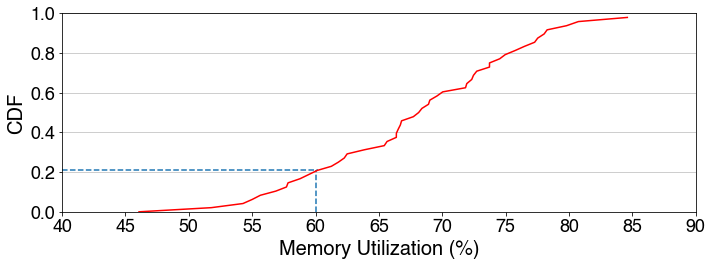

0.20833333333333334

In [49]:
"""plot cdfs for mem utilization"""

FONT_SM = 18
FONT_LR = 20

subtitlefs = FONT_LR
xylabelfs = FONT_LR
xyticksfs = FONT_SM
legendfs = FONT_SM

def plot_cdf(ax, df, data_label, color, label):

    x = df[data_label]
    x, y = sorted(x), np.arange(len(x)) / len(x)
    
    ax.axvline(x=60, ymin=0.0, ymax=0.20833333333333334, ls='--') #, color='blue')
    ax.axhline(y=0.20833333333333334, xmin=0.0, xmax=0.4032, ls='--') #, color='blue')

    ax.plot(x, y, label=label, color=color)

    ax.set_xlabel('Memory Utilization (%)', fontsize=xylabelfs, fontname='Helvetica')
    ax.set_ylabel('CDF', fontsize=xylabelfs, fontname='Helvetica')

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')
    
    return x, y
    
    # loc='upper right',

#     ax.legend(loc='center', bbox_to_anchor=(0.5, 1.125), \
#                fontsize=legendfs, borderaxespad=0., borderpad=0.2, ncol=5, frameon=False,\
#              handletextpad=0.5, labelspacing=2, handlelength=1.75, columnspacing=1.5)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,3.8))

# plot_cdf(ax1, df, "mem_util_min", "blue", "Min")
# plot_cdf(ax1, df, "mem_util_25%", "orange", "$Q_{1}$")
x, y = plot_cdf(ax1, df, "mem_util_median", "red", "Median")
# plot_cdf(ax1, df, "mem_util_75%", "green", "$Q_{3}$")
# plot_cdf(ax1, df, "mem_util_max", "purple", "Max")


ax1.set_xticks(range(40, 90+1, 5))
ax1.set_xticklabels(range(40, 90+1, 5), fontsize=xyticksfs)

ax1.set_ylim(0, 1)
ax1.set_yticks(np.arange(0, 1.01, 0.20))
ax1.set_yticklabels([0.0, .2, .4, .6, .8, 1.0], fontsize=xyticksfs)


# ax1.hlines(y=0.2127659574468085, xmin=40, xmax=60, linestyles='dashed', color='grey')

plt.tight_layout()

# ax1.grid(axis='y')

# ax1.set_facecolor('white')

plt.savefig(f"plots/cdf_mem_util.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)



plt.show()

# y[]
x_int = list(map(int, x))
y[x_int.index(60)]
# np.where(x_int == 60)

In [20]:
subtitlefs = 16
xylabelfs = 16
xyticksfs = 15
legendfs = 14

fig_height = 3

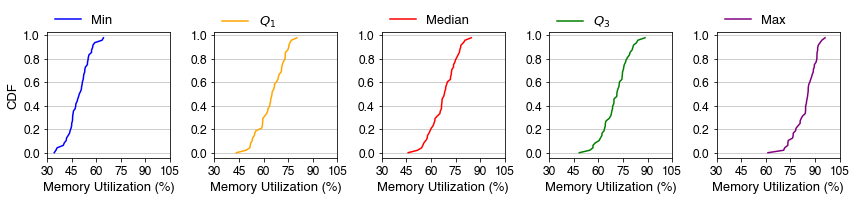

In [22]:
"""plot cdfs for mem utilization"""

def plot_cdf(ax, df, data_label, color, label, ylabel=False):

    x = df[data_label]
    x, y = sorted(x), np.arange(len(x)) / len(x)

    ax.plot(x, y, label=label, color=color)

    ax.set_xlabel('Memory Utilization (%)', fontsize=13, fontname='Helvetica')
    if ylabel:
        ax.set_ylabel('CDF', fontsize=13, fontname='Helvetica')
    else:
        ax.set_ylabel('', fontsize=1, fontname='Helvetica')

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.legend(bbox_to_anchor=(0, 1.2), loc=2, fontsize=13, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

    ax.set_xticks(range(30, 105+1, 15))
    ax.set_xticklabels(range(30, 105+1, 15), fontsize=12)

    ax.set_yticks(np.arange(0, 1.01, 0.20))
    ax.set_yticklabels([0.0, .2, .4, .6, .8, 1.0], fontsize=12)

   


fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,fig_height))

plot_cdf(ax[0], df, "mem_util_min", "blue", "Min", ylabel=True)
plot_cdf(ax[1], df, "mem_util_25%", "orange", "$Q_{1}$")
plot_cdf(ax[2], df, "mem_util_median", "red", "Median")
plot_cdf(ax[3], df, "mem_util_75%", "green", "$Q_{3}$")
plot_cdf(ax[4], df, "mem_util_max", "purple", "Max")

plt.tight_layout()

# ax1.grid(axis='y')

# ax1.set_facecolor('white')

plt.savefig(f"plots/cdf_mem_util_seperated.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

plt.show()

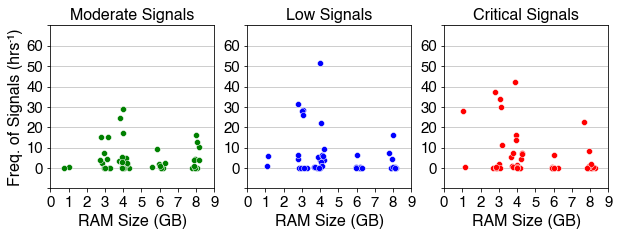

In [23]:
"""plot scatter plots for freq of signals"""

def plot_scatterplot(ax, df, data_label, color, label, ylabel=False):

    def jitter(values, j):
        return values + np.random.normal(j,0.15,values.shape)

    x = jitter(np.array(list(map(math.ceil, df["total_memory"]/1000))), 0)
    y = df[data_label]

    sns.scatterplot(x=x, y=y, ax=ax, color=color, alpha=1)

    ax.set_xlabel('RAM Size (GB)', fontsize=xylabelfs, fontname='Helvetica')
    
    if ylabel:
        ax.set_ylabel('Freq. of Signals (hrs⁻¹)', fontsize=xylabelfs, fontname='Helvetica')
    else:
        ax.set_ylabel('', fontsize=xylabelfs, fontname='Helvetica')

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')
    
    ax.set_title(label, fontsize=subtitlefs)
    
    ax.set_xticks(range(0, 9+1, 1))
    ax.set_xticklabels(range(0, 9+1, 1), fontsize=xyticksfs)
    ax.set_yticks(np.arange(-10, 70+1, 10))
    ax.set_yticklabels([''] + list(range(0, 60+1, 10)) + [''], fontsize=xyticksfs)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, fig_height))

plot_scatterplot(ax1, df, "moderate_i_per_hour", "green", "Moderate Signals", ylabel=True)
plot_scatterplot(ax2, df, "low_i_per_hour", "blue", "Low Signals")
plot_scatterplot(ax3, df, "critical_i_per_hour", "red", "Critical Signals")

plt.savefig(f"plots/freq_signals.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

plt.show()

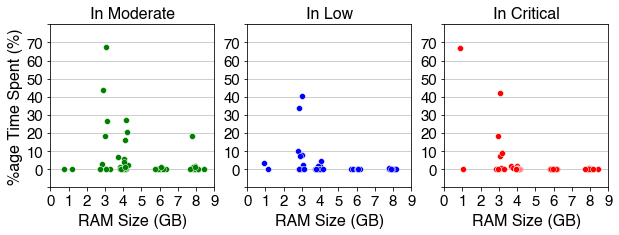

In [25]:
"""plot scatter plots for %age time"""

def plot_scatterplot(ax, df, data_label, color, label, ylabel=False):

    def jitter(values, j):
        return values + np.random.normal(j,0.15,values.shape)

    x = jitter(np.array(list(map(math.ceil, df["total_memory"]/1000))), 0)
    y = df[data_label]

    sns.scatterplot(x=x, y=y, ax=ax, color=color, alpha=1)

    ax.set_xlabel('RAM Size (GB)', fontsize=xylabelfs, fontname='Helvetica')
    
    if ylabel:
        ax.set_ylabel('%age Time Spent (%)', fontsize=xylabelfs, fontname='Helvetica')
    else:
        ax.set_ylabel('', fontsize=xylabelfs, fontname='Helvetica')

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')
    
    ax.set_title(label, fontsize=subtitlefs)

    ax.set_xticks(range(0, 9+1, 1))
    ax.set_xticklabels(range(0, 9+1, 1), fontsize=xyticksfs)
    ax.set_yticks(np.arange(-10, 80+1, 10))
    ax.set_yticklabels([''] + list(range(0, 70+1, 10)) + [''], fontsize=xyticksfs)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, fig_height))

plot_scatterplot(ax1, df, "moderate_i_%agetime", "green", "In Moderate", ylabel=True)
plot_scatterplot(ax2, df, "low_i_%agetime", "blue", "In Low")
plot_scatterplot(ax3, df, "critical_i_%agetime", "red", "In Critical")

plt.savefig(f"plots/time_in_signals.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

plt.show()

In [26]:
df.sort_values(["isigs_%agetime"], ascending=False).head(1).to_csv("temp")

In [27]:
# ((row['total_memory'] - row['overall_mems_df'])/row['total_memory'])*100

Series([], Name: mem_avail, dtype: float64)


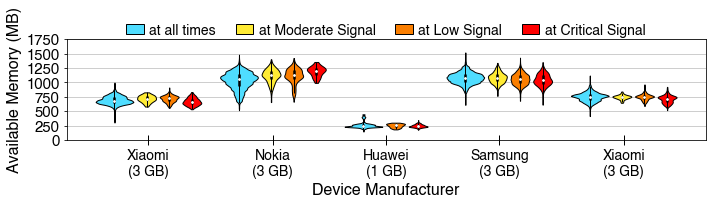

In [28]:
'''Makes a violin plot for the mem distribution in the four devices with the least RAM from among the devices that had more than 15 hours of logged information'''

df_to_plot = df.sort_values(["isigs_%agetime"], ascending=False).head(5).copy()

def adjacent_values(vals, q1, q3):

    vals = sorted(vals)

    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels, positions):

    ax.xaxis.set_tick_params(direction='inout', length=10, width=1)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=0, fontsize=xyticksfs-1, fontname='Helvetica')
    ax.set_xlabel('Device Manufacturer', fontsize=xylabelfs, fontname='Helvetica')
    
    ax.set_ylabel('Available Memory (MB)', fontsize=xylabelfs, fontname='Helvetica')
    ax.set_ylim(0, 1750)
    ax.set_yticks(list(range(0,1750+1,250)))
    ax.set_yticklabels(list(range(0,1750+1,250)), rotation=0, fontsize=xyticksfs, fontname='Helvetica')

# with plt.style.context("seaborn-white"):
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, fig_height))

start_ind = 1
space_between_mem_and_states = 0.25/2 + 0.3
space_between_states = 0.3
space_between_devices = 0.5

start_ind = 1
space_between_mem_and_states = 0.25/2 + 0.3
space_between_states = 0.3

device_count = 0
inds_list = []
labels_list = []
last_plot_ending_x = 0

for index, row in df_to_plot.iterrows():

    if row['manufacturer'] == 'HUAWEI':
        print(row['moderate_mems_df'])

    # # create test data
    # # result = mem_sorted_results[5]
    # memory_data = result['df'].loc[result['df']['apps'] != 'Pressure']['memory'].astype('int32')

    data = [list(row['overall_mems_df'])]

    if len(row['moderate_mems_df']) > 0:
        data.append(list(row['moderate_mems_df']))
    if len(row['low_mems_df']) > 0:
        data.append(list(row['low_mems_df']))
    if len(row['critical_mems_df']) > 0:
        data.append(list(row['critical_mems_df']))

    # set the indices and widths
    # print('states:', (s_i := start_ind + 3*device_count, np.arange(s_i := s_i + space_between_mem_and_states, s_i + space_between_states*3 - 0.1, space_between_states)))

    inds = np.append(s_i := last_plot_ending_x + space_between_devices, np.arange(s_i := s_i + space_between_mem_and_states, s_i + space_between_states*3 - 0.1, space_between_states))[:len(data)]
    
    max_len = max([len(row['moderate_mems_df']), len(row['low_mems_df']), len(row['critical_mems_df'])])
    # print('1:', len(row['moderate_mems_df']), len(row['low_mems_df']), len(row['critical_mems_df']), max_len, sep=',')
    vplot_widths = [
            0.5,
            0.25, # * (len(row['moderate_mems_df']) / max_len),
            0.25, # * (len(row['low_mems_df']) / max_len),
            0.25, # * (len(row['critical_mems_df']) / max_len)
        ]

    # print('vplot_widths:', vplot_widths)

    vplot_widths = vplot_widths[:len(data)]
    # print('inds:', inds)

    last_plot_ending_x = inds[-1] + vplot_widths[-1]/2

    parts = ax.violinplot(
            data, showmeans=False, showmedians=False,
            showextrema=False, positions=inds, widths=vplot_widths)

    for pc in parts['bodies']:
        pc.set_linewidth(1)
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    # parts['bodies'][0].set_facecolor('#4FDDFF') # blue 41D0FF, green 4CE663
    # if len(data) >= 2:
    #     parts['bodies'][1].set_facecolor('#FFEB34')
    #     if len(data) >= 3:
    #         parts['bodies'][2].set_facecolor('#FA7E00')
    #         if len(data) >= 4:
    #             parts['bodies'][3].set_facecolor('#FF0000')

    if len(data) == 3:
        parts['bodies'][0].set_facecolor('#4FDDFF') # blue 41D0FF, green 4CE663
        parts['bodies'][1].set_facecolor('#FA7E00')
        parts['bodies'][2].set_facecolor('#FF0000')
    elif len(data) == 4:
        parts['bodies'][0].set_facecolor('#4FDDFF') # blue 41D0FF, green 4CE663
        parts['bodies'][1].set_facecolor('#FFEB34')
        parts['bodies'][2].set_facecolor('#FA7E00')
        parts['bodies'][3].set_facecolor('#FF0000')

    quartile1 = []
    medians = []
    quartile3 = []
    for item in data:
        q1, median, q3 = np.percentile(item, [25, 50, 75])
        # print('percentile', q1, median, q3)
        quartile1.append(q1)
        medians.append(median)
        quartile3.append(q3)

    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    # print('whiskers:', whiskers)

    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2.5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    ax.scatter(inds, medians, marker='o', color='white', s=3, zorder=2)
    
    inds_list.append((inds[0]-vplot_widths[0]/2 + inds[-1]+vplot_widths[-1]/2)/2)
    
    device_name = row["manufacturer"]
    if device_name == "HMD Global":
        device_name = "Nokia"
    elif device_name == "samsung":
        device_name = "Samsung"
    elif device_name == "HUAWEI":
        device_name = "Huawei"

    labels_list.append(f'{device_name}\n({int(math.ceil(row["total_memory"]/1024))} GB)')

    device_count += 1

# set style for the axes
set_axis_style(ax, labels_list, inds_list)

# p0 = mpatches.Patch(color='#FFFFFF', label='Available Memory')
p1 = mpatches.Patch(color='#4FDDFF', ec='black', label='at all times')
p2 = mpatches.Patch(color='#FFEB34', ec='black', label='at Moderate Signal')
p3 = mpatches.Patch(color='#FA7E00', ec='black', label='at Low Signal')
p4 = mpatches.Patch(color='#FF0000', ec='black', label='at Critical Signal')

ax.legend(handles=[p1,p2,p3, p4], bbox_to_anchor=(0.5, 1.09),
          loc='center', fontsize=legendfs, borderaxespad=0., borderpad=1,
          frameon=False, facecolor='white', ncol=4,\
          handlelength=1.25, handletextpad=0.4, columnspacing=1.4) #, title='Memory Status', title_fontsize=13)

#     ax.legend(loc='center', bbox_to_anchor=(0.5, 1.125), \
#                fontsize=legendfs, borderaxespad=0., borderpad=0.2, ncol=5, frameon=False,\
#              handletextpad=0.5, labelspacing=2, handlelength=1.75, columnspacing=1.5)

plt.title('', fontsize=18)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.savefig(f"plots/violinplot_availmem.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

# plt.show()

plt.tight_layout()

In [29]:
parsed_columns = [
    "file_name",
    "age_group",
    "How often are games played on this device?",
    "How often are videos streamed on this device e.g. on YouTube, Facebook, Tiktok, or a web browser etc.?",
    "How often is music listened to on this device?",
    "How often does the device user multitask with more than one app?",
    "How often does the device user multitask with more than two apps?",
    "Any other memory/cpu intensive activity in your knowledge that is performed on this device? (e.g. video editing, BitTorrent, etc.)",
    "manufacturer",
    "total_memory",
    "threshold",
    "isLowRAM",
    "cpu_cores",
    "API_level",
    "time_logged",
    "time_interactive",
    "num_of_neg_time_diffs",
    "time_not_logged",
    "time_overestimate",
    "last_time_logged",
    "mem_avail_mean",
    "mem_avail_std",
    "mem_avail_min",
    "mem_avail_25%",
    "mem_avail_median",
    "mem_avail_75%",
    "mem_avail_max",
    "mem_util_mean",
    "mem_util_std",
    "mem_util_min",
    "mem_util_25%",
    "mem_util_median",
    "mem_util_75%",
    "mem_util_max",
    "time_normal",
    "time_normal_i",
    "time_moderate",
    "time_low",
    "time_critical",
    "time_ui_hidden",
    "time_ui_hidden_i",
    "time_mem_background",
    "time_mem_background_i",
    "time_mem_moderate",
    "time_mem_moderate_i",
    "time_mem_complete",
    "time_mem_complete_i",
    "time_power_save",
    "time_battery_low",
    "time_music_playing",
    "time_i_music_playing",
    "sigs_not_logged",
    "isigs_that_dont_have_m_logged",
    "sigs_count",
    "sigs_per_hour",
    "isigs_count",
    "isigs_per_hour",
    "time_isigs",
    "imsigs_per_hour",
    "isigs_%agetime",
    "moderate_count",
    "moderate_per_hour",
    "moderate_count_i",
    "moderate_i_per_hour",
    "time_moderate_i",
    "moderate_i_%agetime",
    "moderatemem_avail_mean",
    "moderatemem_avail_std",
    "moderatemem_avail_min",
    "moderatemem_avail_25%",
    "moderatemem_avail_median",
    "moderatemem_avail_75%",
    "moderatemem_avail_max",
    "moderate_count_im",
    "moderate_im_per_hour",
    "low_count",
    "low_per_hour",
    "low_count_i",
    "low_i_per_hour",
    "time_low_i",
    "low_i_%agetime",
    "lowmem_avail_mean",
    "lowmem_avail_std",
    "lowmem_avail_min",
    "lowmem_avail_25%",
    "lowmem_avail_median",
    "lowmem_avail_75%",
    "lowmem_avail_max",
    "low_count_im",
    "low_im_per_hour",
    "critical_count",
    "critical_per_hour",
    "critical_count_i",
    "critical_i_per_hour",
    "time_critical_i",
    "critical_i_%agetime",
    "criticalmem_avail_mean",
    "criticalmem_avail_std",
    "criticalmem_avail_min",
    "criticalmem_avail_25%",
    "criticalmem_avail_median",
    "criticalmem_avail_75%",
    "criticalmem_avail_max",
    "critical_count_im",
    "critical_im_per_hour",
    "other_sig_count",
    "overall_mems_df",
    "moderate_mems_df",
    "low_mems_df",
    "critical_mems_df",
]

In [30]:
value = 10

print('m/l/c per hour:', a:= ((len(df[df["isigs_per_hour"] > value])/len(df))*100), len(df[df["isigs_per_hour"] > value]))
print('critical per hour:', (len(df[df["critical_i_per_hour"] > value])/len(df))*100, len(df[df["critical_i_per_hour"] > value]))
print('low per hour:', (len(df[df["low_i_per_hour"] > value])/len(df))*100, len(df[df["low_i_per_hour"] > value]))
print('moderate per hour:', (len(df[df["moderate_i_per_hour"] > value])/len(df))*100, len(df[df["moderate_i_per_hour"] > value]))

df["m_l_c_sig_i_per_hour"] = df["moderate_i_per_hour"] + df["low_i_per_hour"] + df["critical_i_per_hour"]
assert a == (len(df[df["m_l_c_sig_i_per_hour"] > value])/len(df))*100


m/l/c per hour: 39.58333333333333 19
critical per hour: 18.75 9
low per hour: 14.583333333333334 7
moderate per hour: 16.666666666666664 8


In [31]:
value = 2

print('moderate/low/critical %age time:', a:= ((len(df[df["isigs_%agetime"] >= value])/len(df))*100), len(df[df["isigs_%agetime"] >= value]))
print('critical %age time:', (len(df[df["critical_i_%agetime"] >= value])/len(df))*100, len(df[df["critical_i_%agetime"] >= value]))
print('low %age time:', (len(df[df["low_i_%agetime"] >= value])/len(df))*100, len(df[df["low_i_%agetime"] >= value]))
print('moderate %age time:', (len(df[df["moderate_i_%agetime"] >= value])/len(df))*100, len(df[df["moderate_i_%agetime"] >= value]))

df["m_l_c_sig_i_%agetime"] = df["moderate_i_%agetime"] + df["low_i_%agetime"] + df["critical_i_%agetime"]
assert a == (len(df[df["m_l_c_sig_i_%agetime"] >= value])/len(df))*100
 

moderate/low/critical %age time: 35.41666666666667 17
critical %age time: 10.416666666666668 5
low %age time: 16.666666666666664 8
moderate %age time: 27.083333333333332 13


In [33]:
activities = ['How often are games played on this device?',
'How often are videos streamed on this device e.g. on YouTube, Facebook, Tiktok, or a web browser etc.?',
'How often is music listened to on this device?']

ratings_df = df[activities]

a = ratings_df['How often are games played on this device?'].apply(int).rename('rating').to_frame()
b = ratings_df['How often is music listened to on this device?'].apply(int).rename('rating').to_frame()
c = ratings_df['How often are videos streamed on this device e.g. on YouTube, Facebook, Tiktok, or a web browser etc.?'].apply(int).rename('rating').to_frame()

a['activity'] = 0
b['activity'] = 1
c['activity'] = 2

a['activity_label'] = 'Playing games'
b['activity_label'] = 'Listening to music'
c['activity_label'] = 'Streaming videos'

a['counter'] = 1
b['counter'] = 1
c['counter'] = 1

ratings_df = a.append(b, ignore_index=True).append(c, ignore_index=True)
ratings_df

n_tasks = ["How often does the device user multitask with more than one app?", "How often does the device user multitask with more than two apps?"]
multitask_df = df[n_tasks]
a = multitask_df[n_tasks[0]].apply(int).rename('rating').to_frame()
b = multitask_df[n_tasks[1]].apply(int).rename('rating').to_frame()
a['n_tasks'] = 0
b['n_tasks'] = 1
a['n_tasks_label'] = 'Multitasking with > 1 apps'
b['n_tasks_label'] = 'Multitasking with > 2 apps'
a['counter'] = 1
b['counter'] = 1
multitask_df = a.append(b, ignore_index=True)
multitask_df


,rating,n_tasks,n_tasks_label,counter
0,3,0,Multitasking with > 1 apps,1
1,5,0,Multitasking with > 1 apps,1
2,2,0,Multitasking with > 1 apps,1
3,4,0,Multitasking with > 1 apps,1
4,3,0,Multitasking with > 1 apps,1
...,...,...,...,...
91,2,1,Multitasking with > 2 apps,1
92,4,1,Multitasking with > 2 apps,1
93,5,1,Multitasking with > 2 apps,1
94,4,1,Multitasking with > 2 apps,1


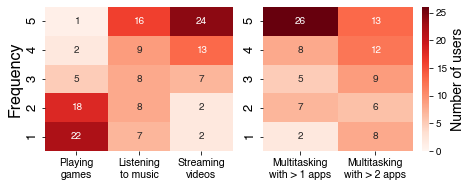

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6.7, fig_height-0.3))

# sns.boxplot(data=ratings_df, x='activity', y='rating', ax=ax1)
# ax1.set_xticklabels(['Playing\ngames', 'Listening\nto music', 'Streaming\nvideos'], fontsize=xyticksfs-2.5)
# ax1.tick_params(axis='y', which='major', labelsize=xyticksfs)
# ax1.set_ylabel('User\'s score of frequency', fontsize=xylabelfs-2)
# ax1.set_xlabel('', fontsize=xylabelfs)

df_pivot = pd.pivot_table(ratings_df, values='counter', index=['rating'], columns=['activity'], aggfunc=np.sum)
sns.heatmap(df_pivot.sort_index(ascending=False), ax=ax1, cmap="Reds", annot=True, vmin=0, vmax=26, cbar=False) # ,vmin=0, vmax=5
ax1.set_xticklabels(['Playing\ngames', 'Listening\nto music', 'Streaming\nvideos'], fontsize=xyticksfs-4.5)
ax1.tick_params(axis='y', which='major', labelsize=xyticksfs-2)
ax1.set_ylabel('Frequency', fontsize=xylabelfs)
ax1.set_xlabel('', fontsize=xylabelfs)


# sns.boxplot(data=multitask_df, x='n_tasks', y='rating', ax=ax2)
# ax2.set_xticklabels(['Multitasking\nwith > 1 apps', 'Multitasking\nwith > 2 apps'], fontsize=xyticksfs-2.5)
# ax2.tick_params(axis='y', which='major', labelsize=xyticksfs)
# ax2.set_ylabel('', fontsize=xylabelfs-2)
# ax2.set_xlabel('', fontsize=xylabelfs)

# def jitter(values, j):
#     return values + np.random.normal(j,0.1,values.shape)

# x = jitter(multitask_df['n_tasks'], 0)
# y = jitter(multitask_df["rating"].to_numpy(), 0)
# sns.scatterplot(x=x, y=y, ax=ax2)


df_m = pd.pivot_table(multitask_df, values='counter', index=['rating'], columns=['n_tasks'], aggfunc=np.sum)
sns.heatmap(df_m.sort_index(ascending=False), ax=ax2, cmap="Reds", annot=True, vmin=0, vmax=26, cbar_kws={'label': 'Number of users'})
ax2.figure.axes[-1].yaxis.label.set_size(xylabelfs-2)
ax2.set_xticklabels(['Multitasking\nwith > 1 apps', 'Multitasking\nwith > 2 apps'], fontsize=xyticksfs-4.5)
ax2.tick_params(axis='y', which='major', labelsize=xyticksfs-2)
ax2.set_ylabel('', fontsize=xylabelfs)
ax2.set_xlabel('', fontsize=xylabelfs)


plt.tight_layout()

plt.savefig(f"plots/user_workloads_response.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)
